# Spam Email Detection
Create models to predict if an email message is spam or not

1. CountVectorizer & Multinomial Naive Bayes Classifier
2. TfidfVectorizer & Multinomial Naive Bayes Classifier
3. TfidfVectorizer & Support Vector Classification + Length of Document
4. TfidfVectorizer & Logistic Regression + Length of Document + # of digits per Document
5. CountVectorizer & Logistic Regression + + Length of Document + # of digits per Document + # of Non-word Characters

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

spam_data = pd.read_csv('./Data/spam.csv')

spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


## Data Exploration

In [2]:
print("Percentage of spam in the data is", len(spam_data[spam_data['target'] == 1])/len(spam_data) * 100)

Percentage of spam in the data is 13.406317300789663


### Finding 1: Spam message tends to be longer

In [3]:
not_spam = spam_data[spam_data['target'] == 0]['text']
spam = spam_data[spam_data['target'] == 1]['text']
avg_not_spam_doc_length = sum([len(x) for x in not_spam]) / len(not_spam)
avg_spam_doc_length = sum([len(x) for x in spam]) / len(spam)
    
print("Average length of NOT spam message is", avg_not_spam_doc_length)
print("Average length of spam message is", avg_spam_doc_length)

Average length of NOT spam message is 71.02362694300518
Average length of spam message is 138.8661311914324


### Finding 2: Spam message tends to have more digits

In [4]:
not_spam = spam_data[spam_data['target'] == 0]['text']
spam = spam_data[spam_data['target'] == 1]['text']
avg_not_spam_digits = sum([sum(c.isdigit() for c in x) for x in not_spam])/len(not_spam)
avg_spam_digits = sum([sum(c.isdigit() for c in x) for x in spam])/len(spam)

print("Average number of digits per document of NOT spam message is", avg_not_spam_digits)
print("Average number of digits per document of spam message is", avg_spam_digits)

Average number of digits per document of NOT spam message is 0.2992746113989637
Average number of digits per document of spam message is 15.759036144578314


### Finding 3: Spam message tends to have more non-word characters

In [5]:
import re
not_spam = spam_data[spam_data['target'] == 0]['text']
spam = spam_data[spam_data['target'] == 1]['text']
avg_not_spam_non_word = sum([len(re.findall('\W', x)) for x in not_spam])/len(not_spam)
avg_spam_non_word = sum([len(re.findall('\W', x)) for x in spam])/len(spam)
    
print("Average number of non-word characters per document of NOT spam message is", avg_not_spam_non_word)
print("Average number of non-word characters per document of spam message is", avg_spam_non_word)

Average number of non-word characters per document of NOT spam message is 17.29181347150259
Average number of non-word characters per document of spam message is 29.041499330655956


### Visualize Findings

In [6]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.style as style
import seaborn as sns

sns.reset_defaults()
style.use('fivethirtyeight')
colors = ["darkgreen", "darkred"]
sns.set_palette(sns.color_palette(colors))
matplotlib.rcParams['font.family'] = "serif"
plt.figure(figsize=(8,2))

<Figure size 800x200 with 0 Axes>

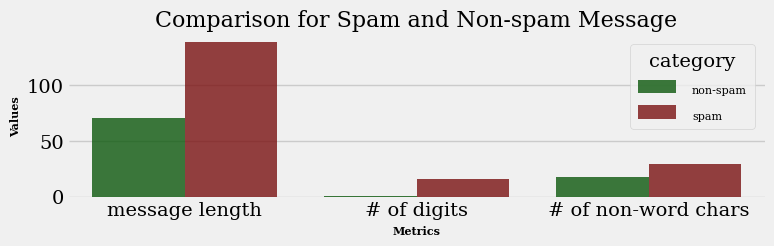

In [7]:
doc_length_df = pd.DataFrame({'values': [avg_not_spam_doc_length, avg_spam_doc_length], 'metrics': 'message length', 'category': ['non-spam', 'spam']})
digits_num_df = pd.DataFrame({'values': [avg_not_spam_digits, avg_spam_digits], 'metrics': '# of digits', 'category': ['non-spam', 'spam']})
non_word_df = pd.DataFrame({'values': [avg_not_spam_non_word, avg_spam_non_word], 'metrics': '# of non-word chars', 'category': ['non-spam', 'spam']})
dfs = [doc_length_df, digits_num_df, non_word_df]
summary_df = pd.concat(dfs)
plot = sns.barplot(x='metrics', y='values', hue='category', data=summary_df, alpha=0.8)
sns.despine(left=True, bottom=True)
title = plot.set_title('Comparison for Spam and Non-spam Message', fontsize=16)
xlabel = plot.set_xlabel('Metrics', weight='bold', fontsize=8)
ylabel = plot.set_ylabel('Values', weight='bold', fontsize=8)
legend = plt.setp(plot.get_legend().get_texts(), fontsize=8)

plt.show()

## Modeling

In [8]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], 
                                                    spam_data['target'], 
                                                    random_state=0)

### 1. CountVectorizer & Multinomial Naive Bayes Classifier

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

def model1():
    vectorizer = CountVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    clf = MultinomialNB(alpha=0.1)
    clf.fit(X_train_vectorized, y_train)
    y_scores = clf.predict(X_test_vectorized)
    
    return roc_auc_score(y_test, y_scores)

### 2. TfidfVectorizer & Multinomial Naive Bayes Classifier

- ignoring terms that have a document frequency strictly lower than **3**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

def model2():
    vectorizer = TfidfVectorizer(min_df=3)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    clf = MultinomialNB(alpha=0.1)
    clf.fit(X_train_vectorized, y_train)
    y_scores = clf.predict(X_test_vectorized)
    
    return roc_auc_score(y_test, y_scores)

### 3. TfidfVectorizer & Support Vector Classification + Length of Document

- ignoring terms that have a document frequency strictly lower than **5**.

Function that help combine new features into the training data:

In [11]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [12]:
from sklearn.svm import SVC

def model3():
    vectorizer = TfidfVectorizer(min_df=5)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_train_vectorized = add_feature(X_train_vectorized, [len(x) for x in X_train])
    X_test_vectorized = vectorizer.transform(X_test)
    X_test_vectorized = add_feature(X_test_vectorized, [len(x) for x in X_test])
    clf = SVC(C=10000, random_state=0)
    clf.fit(X_train_vectorized, y_train)
    y_scores = clf.predict(X_test_vectorized)
    
    return roc_auc_score(y_test, y_scores)

### 4. TfidfVectorizer & Logistic Regression + Length of Document + # of digits per Document

- ignoring terms that have a document frequency strictly lower than **5**
- using **word n-grams from n=1 to n=3** (unigrams, bigrams, and trigrams).

In [13]:
from sklearn.linear_model import LogisticRegression

def model4():
    vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,3))
    X_train_vectorized = vectorizer.fit_transform(X_train)
    
    X_train_vectorized = add_feature(X_train_vectorized, [[len(x) for x in X_train], [sum(c.isdigit() for c in x) for x in X_train]])
    X_test_vectorized = vectorizer.transform(X_test)
    X_test_vectorized = add_feature(X_test_vectorized, [[len(x) for x in X_test], [sum(c.isdigit() for c in x) for x in X_test]])
    
    clf = LogisticRegression(C=100, random_state=0)
    clf.fit(X_train_vectorized, y_train)
    y_scores = clf.predict(X_test_vectorized)
    
    return roc_auc_score(y_test, y_scores)

### 5. CountVectorizer & Logistic Regression + Length of Document + # of digits per Document + # of Non-word Characters

- ignoring terms that have a document frequency strictly lower than **5**
- using **character n-grams from n=2 to n=5.**

In [14]:
def model5():
    vectorizer = CountVectorizer(min_df=5, ngram_range=(2,5), analyzer='char_wb')
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_train_vectorized = add_feature(X_train_vectorized, [[len(x) for x in X_train], [sum(c.isdigit() for c in x) for x in X_train], [sum(not c.isalnum() for c in x) for x in X_train]])
    X_test_vectorized = vectorizer.transform(X_test)
    X_test_vectorized = add_feature(X_test_vectorized, [[len(x) for x in X_test], [sum(c.isdigit() for c in x) for x in X_test], [sum(not c.isalnum() for c in x) for x in X_test]])
    clf = LogisticRegression(C=100, random_state=0)
    clf.fit(X_train_vectorized, y_train)
    y_scores = clf.predict(X_test_vectorized)
        
    return roc_auc_score(y_test, y_scores)

### Model Comparison

In [15]:
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']

auc_scores = [model1(), model2(), model3(), model4(), model5()]

added_features = [None, None, 'len(doc)', 'len(doc) + # digits per doc', \
                 'len(doc) + # digits per doc + # non-word chars']

text_converter = ['CountVectorizer', 'TfidfVectorizer', 'TfidfVectorizer', 'TfidfVectorizer', 'CountVectorizer']

classifiers = ['Multinomial Naive Bayes Classifier', 'Multinomial Naive Bayes Classifier', \
                 'Support Vector Classification', 'Logistic Regression', 'Logistic Regression']

In [16]:
model_comparsion = pd.DataFrame({'auc_scores': auc_scores, 'text_converter': text_converter, \
                                 'classifiers': classifiers, 'added_features': added_features}, index=model_names)
model_comparsion.sort_values(by='auc_scores', ascending=False)

,auc_scores,text_converter,classifiers,added_features
Model 5,0.981397,CountVectorizer,Logistic Regression,len(doc) + # digits per doc + # non-word chars
Model 4,0.975903,TfidfVectorizer,Logistic Regression,len(doc) + # digits per doc
Model 1,0.972081,CountVectorizer,Multinomial Naive Bayes Classifier,None
Model 3,0.966169,TfidfVectorizer,Support Vector Classification,len(doc)
Model 2,0.941624,TfidfVectorizer,Multinomial Naive Bayes Classifier,None


### The best model is Model 5

Find the 10 smallest and 10 largest coefficients from the model 